In [2]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


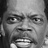

In [4]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [5]:
np.array(sample_image).shape

(48, 48)

In [6]:
# normalize all the images from the dataset
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)


In [7]:
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'bad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

(18280, 200, 200, 1) (18280, 7)
(4570, 200, 200, 1) (4570, 7)


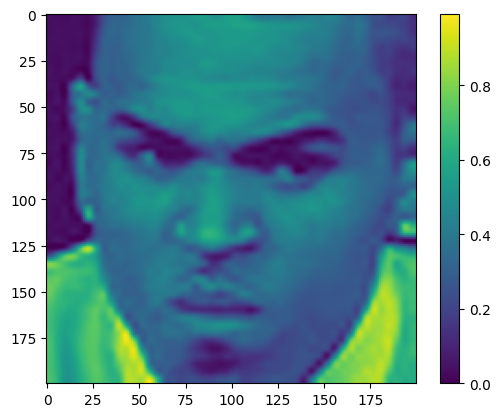

In [8]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

# Obstruct the Top 1/3 of the Facial Images

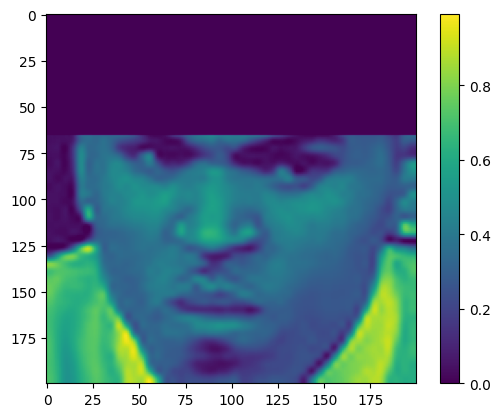

In [30]:
# obstruct the top 1/3 of the image
x_train_obstructed_up = x_train.copy()
x_train_obstructed_up[:, :66, :, :] = 0
x_val_obstructed_up = x_val.copy()
x_val_obstructed_up[:, :66, :, :] = 0

plt.imshow(x_train_obstructed_up[0,:,:,0])
plt.colorbar()

In [31]:
# train and fit a resnet50 model
resnet50_model_top = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_up[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_top.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [32]:
# add batch normalization and dropout
for layer in resnet50_model_top.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_top.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [33]:
n_epoch = 20
# train the model
resnet50_model_top.fit(x_train_obstructed_up, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_up, y_val),
                callbacks=[callback])

Epoch 1/20
572/572 [==============================] - 70s 59ms/step - loss: 1.6252 - categorical_accuracy: 0.3358 - val_loss: 1.8563 - val_categorical_accuracy: 0.3260
Epoch 2/20
572/572 [==============================] - 32s 57ms/step - loss: 1.4341 - categorical_accuracy: 0.4260 - val_loss: 1.4972 - val_categorical_accuracy: 0.3919
Epoch 3/20
572/572 [==============================] - 33s 57ms/step - loss: 1.2758 - categorical_accuracy: 0.5061 - val_loss: 1.7679 - val_categorical_accuracy: 0.3630
Epoch 4/20
572/572 [==============================] - 33s 58ms/step - loss: 1.1277 - categorical_accuracy: 0.5664 - val_loss: 1.2739 - val_categorical_accuracy: 0.4963
Epoch 5/20
572/572 [==============================] - 33s 58ms/step - loss: 1.0302 - categorical_accuracy: 0.6039 - val_loss: 2.5247 - val_categorical_accuracy: 0.2947
Epoch 6/20
572/572 [==============================] - 33s 57ms/step - loss: 0.9121 - categorical_accuracy: 0.6495 - val_loss: 1.4507 - val_categorical_accuracy:

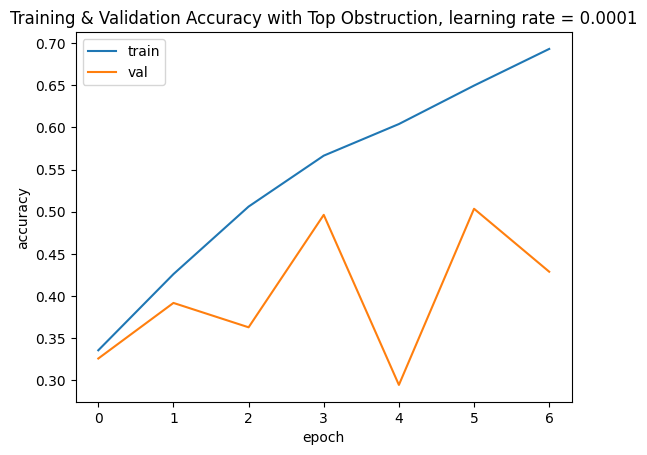

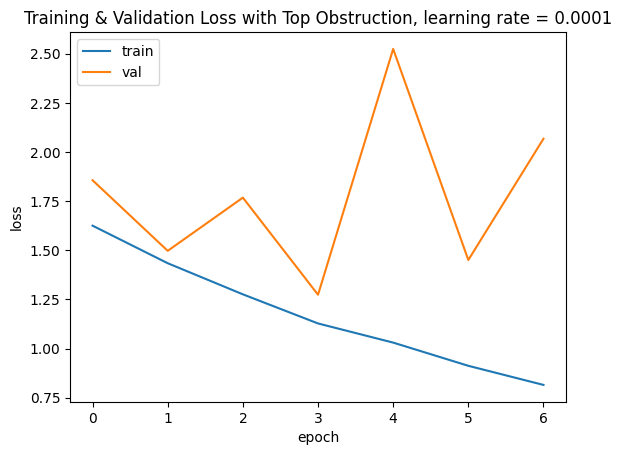

In [34]:
# plot the accuracy and loss
plt.plot(resnet50_model_top.history.history['categorical_accuracy'])
plt.plot(resnet50_model_top.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Top Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_top.history.history['loss'])
plt.plot(resnet50_model_top.history.history['val_loss'])
plt.title('Training & Validation Loss with Top Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [35]:
# save the model
resnet50_model_top.save('/content/gdrive/My Drive/IDS705/resnet50_model_bn_upper_face')

# Obstruct the Middle 1/4 of the Facial Images

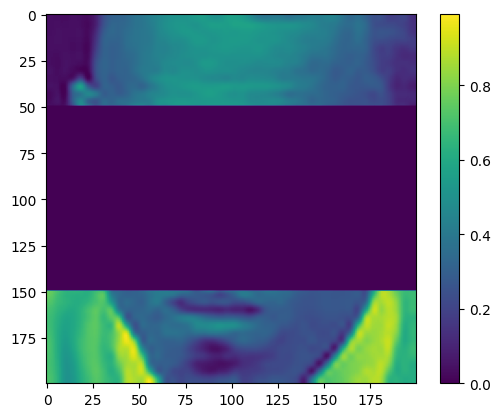

In [18]:
# obstruct the middle 1/4 of the images
x_train_obstructed_middle = x_train.copy()
x_train_obstructed_middle[:, 50:150, :, :] = 0
x_val_obstructed_middle = x_val.copy()
x_val_obstructed_middle[:, 50:150, :, :] = 0

plt.imshow(x_train_obstructed_middle[0,:,:,0])
plt.colorbar()

In [19]:
# train a resnet50 model
resnet50_model_middle = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_middle[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_middle.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
# add batch normalization and dropout
for layer in resnet50_model_middle.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_middle.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [21]:
n_epoch = 20
# train the model
resnet50_model_middle.fit(x_train_obstructed_middle, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_middle, y_val),
                callbacks=[callback])

Epoch 1/20
572/572 [==============================] - 70s 60ms/step - loss: 1.6624 - categorical_accuracy: 0.3161 - val_loss: 3.2081 - val_categorical_accuracy: 0.3164
Epoch 2/20
572/572 [==============================] - 33s 58ms/step - loss: 1.5243 - categorical_accuracy: 0.3822 - val_loss: 1.7593 - val_categorical_accuracy: 0.3582
Epoch 3/20
572/572 [==============================] - 33s 58ms/step - loss: 1.4099 - categorical_accuracy: 0.4315 - val_loss: 1.5149 - val_categorical_accuracy: 0.3589
Epoch 4/20
572/572 [==============================] - 33s 57ms/step - loss: 1.3384 - categorical_accuracy: 0.4720 - val_loss: 1.9495 - val_categorical_accuracy: 0.2656
Epoch 5/20
572/572 [==============================] - 33s 57ms/step - loss: 1.2569 - categorical_accuracy: 0.5041 - val_loss: 1.5255 - val_categorical_accuracy: 0.4004
Epoch 6/20
572/572 [==============================] - 33s 57ms/step - loss: 1.1873 - categorical_accuracy: 0.5393 - val_loss: 1.6072 - val_categorical_accuracy:

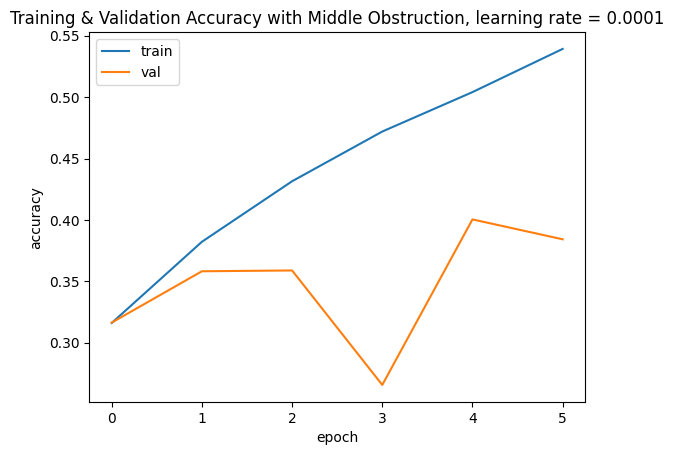

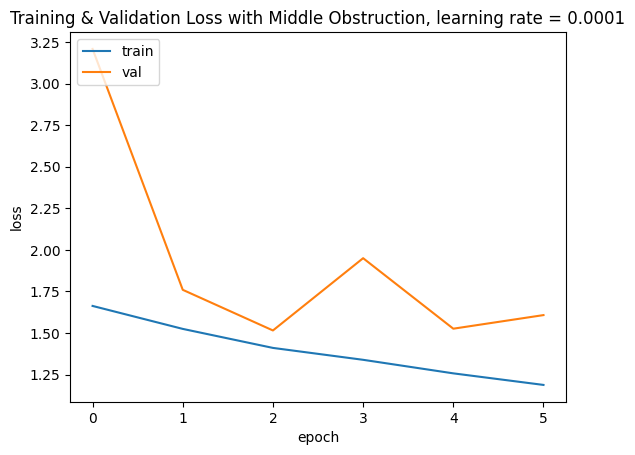

In [22]:
# plot the accuracy and loss
plt.plot(resnet50_model_middle.history.history['categorical_accuracy'])
plt.plot(resnet50_model_middle.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_middle.history.history['loss'])
plt.plot(resnet50_model_middle.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [23]:
# save the model
resnet50_model_middle.save('/content/gdrive/My Drive/IDS705/resnet50_model_bn_middle_face')

# Obstruct the Bottom 1/2 of the Facial Images

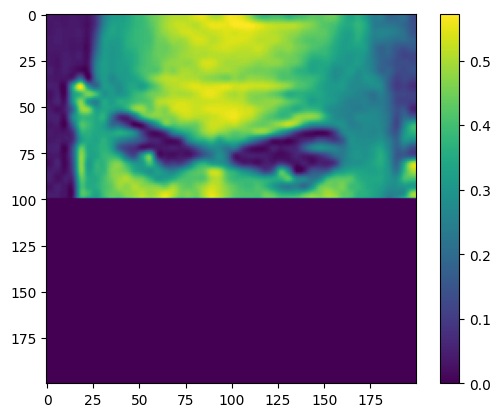

In [24]:
# obstruct the rest of the image, train and fit the resnet50 model
x_train_obstructed_bottom = x_train.copy()
x_train_obstructed_bottom[:, 100:, :, :] = 0
x_val_obstructed_bottom = x_val.copy()
x_val_obstructed_bottom[:, 150:, :, :] = 0

plt.imshow(x_train_obstructed_bottom[0,:,:,0])
plt.colorbar()

In [25]:
# train a resnet50 model
resnet50_model_bottom = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_bottom[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_bottom.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
# add batch normalization and dropout
for layer in resnet50_model_bottom.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bottom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [27]:
n_epoch = 20
# train the model
resnet50_model_bottom.fit(x_train_obstructed_bottom, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_bottom, y_val),
                callbacks=[callback])

Epoch 1/20
572/572 [==============================] - 69s 60ms/step - loss: 1.6859 - categorical_accuracy: 0.2933 - val_loss: 1.7632 - val_categorical_accuracy: 0.2442
Epoch 2/20
572/572 [==============================] - 33s 57ms/step - loss: 1.6362 - categorical_accuracy: 0.3061 - val_loss: 1.6647 - val_categorical_accuracy: 0.3254
Epoch 3/20
572/572 [==============================] - 33s 57ms/step - loss: 1.5741 - categorical_accuracy: 0.3476 - val_loss: 2.4452 - val_categorical_accuracy: 0.1851
Epoch 4/20
572/572 [==============================] - 33s 57ms/step - loss: 1.4979 - categorical_accuracy: 0.3825 - val_loss: 1.7884 - val_categorical_accuracy: 0.3322
Epoch 5/20
572/572 [==============================] - 33s 58ms/step - loss: 1.4396 - categorical_accuracy: 0.4130 - val_loss: 2.0309 - val_categorical_accuracy: 0.2341


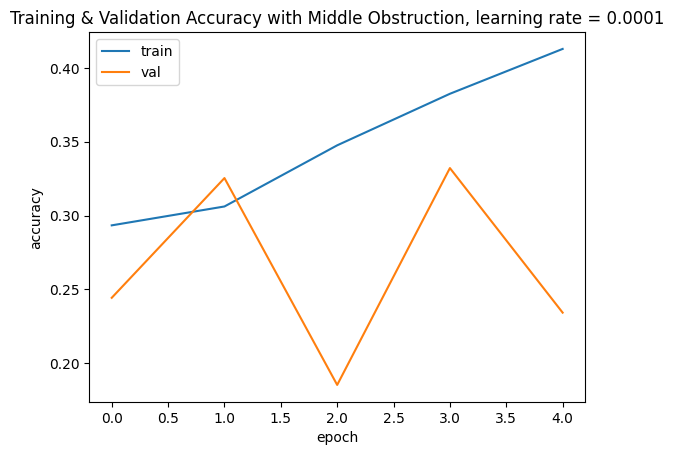

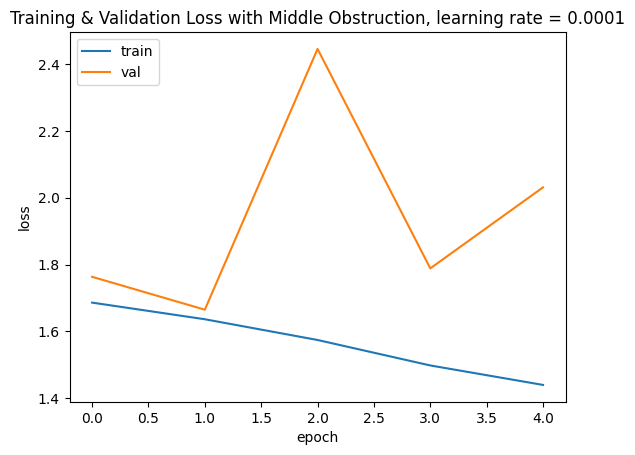

In [28]:
# plot the accuracy and loss
plt.plot(resnet50_model_bottom.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bottom.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bottom.history.history['loss'])
plt.plot(resnet50_model_bottom.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [29]:
# save the model
resnet50_model_middle.save('/content/gdrive/My Drive/IDS705/resnet50_model_bn_bottom_face')